In [1]:
import utils
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder

%load_ext autoreload
%autoreload 2

In [2]:
from utils import MyDataLoader
DL = MyDataLoader()
DL.read_gt("data/clusters.csv")
DL.data.head(10)

,Unnamed: 0,cluster_id,file_name,cluster_num
0,0,5f1f5a4cb43b4a13b1f281d951ed7517,a00ee19f8bdd48a3af5ff78789887ad1.jpg,354
1,1,5f1f5a4cb43b4a13b1f281d951ed7517,9a34cabc4be94126a958267e2e3d1676.jpg,354
2,2,5f1f5a4cb43b4a13b1f281d951ed7517,381529cfa29942f3a30cb35247ff1c63.jpg,354
3,3,5f1f5a4cb43b4a13b1f281d951ed7517,c646ed62b45145c682733cfce9c815d7.jpg,354
4,4,5f1f5a4cb43b4a13b1f281d951ed7517,6a5d90d13fdc47348753144d5a33be71.jpg,354
5,5,5f1f5a4cb43b4a13b1f281d951ed7517,8da290af60ab462c911aaa603824fd52.jpg,354
6,6,5f1f5a4cb43b4a13b1f281d951ed7517,1a6f1972db7e41fdb731bd47433e2090.jpg,354
7,7,5f1f5a4cb43b4a13b1f281d951ed7517,3e7a3af1e0644d9bb417f0b051a8e0ec.jpg,354
8,8,5f1f5a4cb43b4a13b1f281d951ed7517,9ef20db40f2f4cc79efeb76ef5562cf0.jpg,354
9,9,5f1f5a4cb43b4a13b1f281d951ed7517,af1c87f519f2493980cbcd9cc11f5eb6.jpg,354


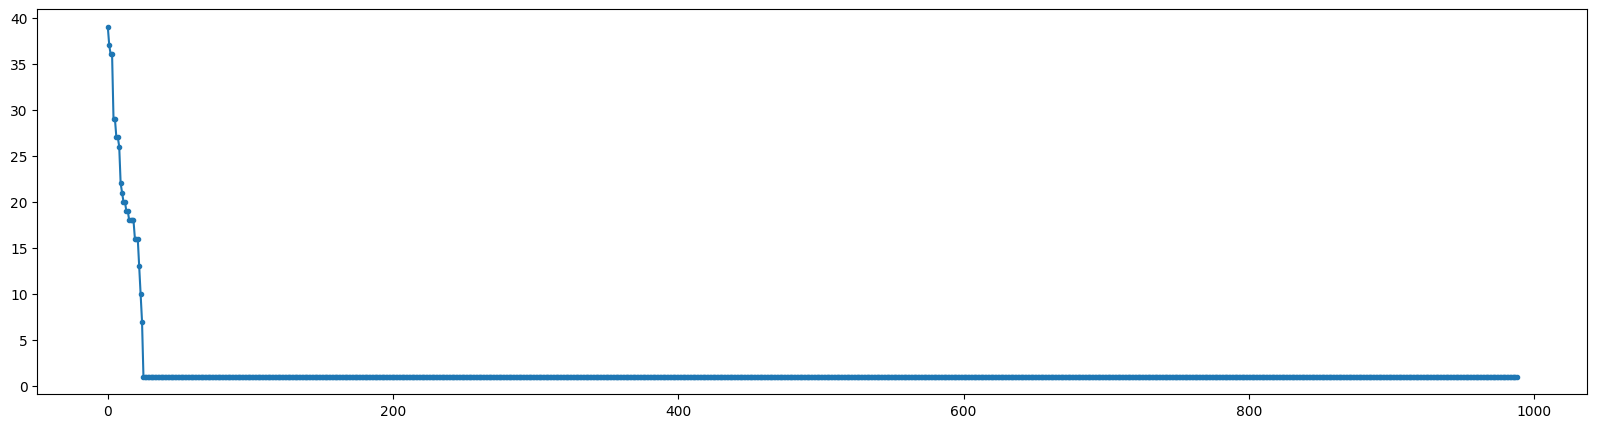

In [3]:
plt.subplots(figsize=(20, 5))
DL.show_stats();

In [4]:
DL.read_encodings("encodings.pkl")

In [5]:
len(DL.encodings)

714

In [7]:
from pathlib import Path
gt, x = [], []
for enc in DL.encodings:
    key = Path(enc["imagePath"]).name
    print(key)
    tmp = DL.data[DL.data.file_name == key]
    if len(tmp):
        gt.append(tmp.cluster_num.values[0])
        x.append(enc["encoding"])

ff6b89dd6fa349a6b0fc63bfa4ef40ca.jpg
55f9676449ff4060aa856622df3fcadf.jpg
4e4e5dd7b2b6423e9851dd706dd08fe7.jpg
747b202a7b8742cf8c462af0188a5c59.jpg
b9e639881d8a40fda4a47efedfcf7981.jpg
2f8afffcb7834667899097138240876d.jpg
58affa46a2de42bc8c06a2779cb29b83.jpg
13ff90096e4e421da0be97b98cb85b5d.jpg
4ca05b9acb4647b899a50ae0156acdd9.jpg
b7309ed4ff864077acb5abbd5a53573b.jpg
99a10a4af34d42fe8cae1d2d430da16f.jpg
fca1d0267afc4f8f943bdb434bcc922f.jpg
17cf99da4cca4cad9e6230cec6ce180f.jpg
b2e3c7d7f6874006bf252c4e1205fb43.jpg
83acdfbd417f41c79d0ffd1dfdd9fcc7.jpg
c1832819f0a34ed1bee629d9d01e1965.jpg
d025cbfe21424b3eaaa7a05bbe5b4225.jpg
8fe2df7a3e0243158ad6a70b70790af9.jpg
cc230a97abd44d87acbae8e8d40993e3.jpg
554daee5bff74bec9fc73177b99c1ed1.jpg
9b5333159266497188a52bc438b25022.jpg
2e7345069ff24faebf8de26afe018f8f.jpg
ee8e813b3a8c4573a448fefe4e869908.jpg
aa01fb52e37c456f88c518a7a0520429.jpg
da25b54271354571a4578ab7425f73b9.jpg
39fa5fbd2151483fabac3c945c33e2a1.jpg
c5f14a243cb54a409011d6b3edcbcdea.jpg
c

In [8]:
len(x)

714

In [60]:
# cluster the embeddings
print("[INFO] clustering...")
clt = DBSCAN(eps=0.35, n_jobs=4)
clt.fit(x)
# determine the total number of unique faces found in the dataset
labelIDs = np.unique(clt.labels_)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print("[INFO] # unique faces: {}".format(numUniqueFaces))

[INFO] clustering...
[INFO] # unique faces: 25


In [61]:
from sklearn.metrics import v_measure_score
v_measure_score(gt, clt.labels_)

0.8607232644241208

[INFO] faces for face ID: -1
[INFO] faces for face ID: 0
[INFO] faces for face ID: 1
[INFO] faces for face ID: 2
[INFO] faces for face ID: 3
[INFO] faces for face ID: 4
[INFO] faces for face ID: 5
[INFO] faces for face ID: 6
[INFO] faces for face ID: 7
[INFO] faces for face ID: 8
[INFO] faces for face ID: 9
[INFO] faces for face ID: 10
[INFO] faces for face ID: 11
[INFO] faces for face ID: 12
[INFO] faces for face ID: 13
[INFO] faces for face ID: 14
[INFO] faces for face ID: 15
[INFO] faces for face ID: 16
[INFO] faces for face ID: 17
[INFO] faces for face ID: 18
[INFO] faces for face ID: 19


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


[INFO] faces for face ID: 20
[INFO] faces for face ID: 21
[INFO] faces for face ID: 22
[INFO] faces for face ID: 23


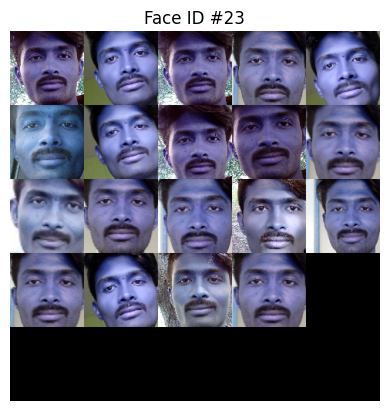

In [6]:
# loop over the unique face integers
for labelID in labelIDs:
    # find all indexes into the `data` array that belong to the
    # current label ID, then randomly sample a maximum of 25 indexes
    # from the set
    print("[INFO] faces for face ID: {}".format(labelID))
    idxs = np.where(clt.labels_ == labelID)[0]
    idxs = np.random.choice(idxs, size=min(25, len(idxs)),
        replace=False)
    # initialize the list of faces to include in the montage
    faces = []
    # loop over the sampled indexes
    for i in idxs:
        # load the input image and extract the face ROI
        try:
            image = cv2.imread(data[i]["imagePath"])
            (top, right, bottom, left) = data[i]["loc"]
            face = image[top:bottom, left:right]
            # force resize the face ROI to 96x96 and then add it to the
            # faces montage list
            face = cv2.resize(face, (96, 96))
            faces.append(face)
        except:
            pass
    # create a montage using 96x96 "tiles" with 5 rows and 5 columns
    montage = build_montages(faces, (96, 96), (5, 5))[0]
    
    # show the output montage
    title = "Unknown Faces" if labelID == -1 else "Face ID #{}".format(labelID)
    plt.imshow(montage)
    plt.axis("off")
    plt.title(title)
    plt.savefig(f"{labelID:03.0f}.png")
